In [1]:
import requests

import pandas as pd
import numpy as np
# from math import pi, cos,radians, log10, sqrt

import seaborn as sns
sns.set_context('talk')

from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord

from astro_calc import ang_distance,p_ser_grb, sig_est

from fink_request import explorer_crossmatch, get_fink_objects

from module_filter import det_history_filter, src_type_filter, cut_grb_mod, ft_finder

from module_utils import get_grb_config, get_pdf_measure, cat_select

from plots import plot_cand_lc

import json

# First step
Let's load the grb config file that stores all the relevant informations to start our searches. We are then extract and load the main informations about our GRB for which we want to identify an optical counterpart !

In [2]:
# Load the grb_config file

grb_config_path = 'grb_config.json'
grb_config = get_grb_config(grb_config_path)
    
cat_file = grb_config['cat_file']
mission_name = grb_config['mission_name']
max_cone_search = grb_config['max_cone_search']
size_time_window = grb_config['size_time_window']
sigma_grb_ass = grb_config['sigma_grb_ass']
grb_det_rate = grb_config['grb_det_rate']
subthreshold_ftsearch = grb_config['subthreshold_ftsearch']

# Load the GRB catalog
cat = cat_select(mission_name,cat_file)

#retrieve the catalog informations of the targeted GRB
index_grb = cat.index
i = index_grb[cat.name == grb_config['selected_burst']][0]
grb_name = cat.name[i]
grb_ra = cat.ra[i]
grb_dec = cat.dec[i]
grb_pos = SkyCoord(grb_ra, grb_dec, unit = 'degree', frame='icrs')
grb_pos_err = cat.error_radius[i]# in deg
cone_radius  = min([max_cone_search,1.5*grb_pos_err])*3600
grb_date = cat.trigger_time[i]


# Second step
Let's launch the explorer crossmatch to retrieve the ZTF candidates. Then we apply a series of filters (we make use of the objects API) to filter out the irrelevant candidates

In [3]:
# perform a spatial and time crossmatch with the ZTF candidates in Fink
pdf_crossmatch = explorer_crossmatch(grb_ra,grb_dec,cone_radius,grb_date,size_time_window)

# kill the source type we don't want 
# (source type filter -> see the grb_config.json to see which types of sources are kept)
pdf_cand = pdf_crossmatch[src_type_filter(pdf_crossmatch,grb_config_path)]

if len(pdf_cand) > 0:
    print(grb_name+" position is: RA = "+str(grb_ra)+" dec = "+str(grb_dec)+\
              " error radius = "+str(cone_radius/3600)+" degrees")
    print(grb_name+" has a positive (time and space) match with "+str(len(pdf_cand))+\
          " ZTF candidates before applying the science cuts")
    print("\r\n")
    
    # Retrieve in a list format the names of the ZTF objects
    ztf_objectIds = pdf_cand['i:objectId'].values.tolist()
    
    #########################################################
    # FROM HERE THERE MAY BE ROOM FOR CODE IMPROVEMENTS, 
    # especially by optimizing the way to process the output 
    # of the objects API based on a list of several objectId
    #########################################################
    # get the ZTF objects (FINK Objects API) to collect the full data set for each ZTF candidate
    list_pdf_objs, dict_pdf_objs = get_fink_objects(ztf_objectIds)

    # build a mask to only select the candidates that have no detected precursor 
    # and no detections 3 months post burst (for very late offline analysis)
    det_hist_mask = det_history_filter(list_pdf_objs,grb_date)
    
    # here is our new filtered panda dataframe for the crossmatched objects (explorer API) and the 
    # list of panda dataframe objects (objects API)
    pdf_cand_sel = pdf_cand[det_hist_mask]
    
    index_sel = [i for i, x in enumerate(det_hist_mask) if x]
    list_pdf_objs_sel = [list_pdf_objs[i] for i in index_sel]
    
    print(str(len(pdf_cand_sel))+" ZTF candidates still alive after applying the detection history filter")
    
    # We compute the delay between the GRB trigger time and the first securely measured data point 
    # for every ZTF candidate
    grb_delays = []
    for ztf_name in pdf_cand_sel['i:objectId'].unique():
        pdf = dict_pdf_objs[ztf_name]

        grb_delays.append((Time(pdf.loc[pdf['i:sigmapsf']>0,'i:jd'].min(), format='jd')-Time(grb_date)).value)

    grb_delays = pd.Series( (v for v in grb_delays) )
    
    # We compute the separation angle between the ZTF candidates and the GRB position
    sep_angles = ang_distance([grb_ra,grb_dec],[pdf_cand_sel['i:ra'].values,pdf_cand_sel['i:dec'].values])
    sep_angles = pd.Series( (v for v in sep_angles.degree.tolist()) )
    
    # Let's now compute the p_ser for every candidate (probability that a ZTF candidate is inside both the
    # the GRB error box and the searching time window by chance)
    p_grb = grb_delays.apply(lambda x: p_ser_grb(grb_pos_err,x/365.25,grb_det_rate))
    
    # here we compute the confidence level for a non serendipituous association between 
    # the GRB and the ZTF candidate
    sigma_ass = p_grb.apply(lambda x: sig_est(1-x[0]))
    
    # Prepare new columns in the pd data frame
    pdf_cand_sel['v:Pser_grb'] = p_grb.apply(lambda x: x[0]).tolist() # the serendipituous probability of a GRB/ZTF candidate association
    pdf_cand_sel['v:grbSigmaAss'] = sigma_ass.apply(lambda x: x[0]).tolist() # the confidence level in sigma associated with 1 - pser
    
    # Apply the science filter cuts 
    print("Applying the science cuts...")
    pdf_science_sel = cut_grb_mod(pdf_cand_sel,grb_config_path)
    if len(pdf_science_sel) > 0:
        print("There is at least one ZTF candidate with a credible association with the "+\
             "Fermi "+grb_name)
        print("List of identified ZTF transient candidates:")
        print(pdf_science['i:objectId'])
    
    else:
        print("Their is no credible association ("+str(sigma_grb_ass)+" sigma C.L.) between "+\
              grb_name+" and the ZTF candidates after applying the science cuts")
            
else:
    print("Their is no credible association between "+grb_name+" and any "+\
              "ZTF candidates detected in the time window TGRB +"+str(size_time_window)+" days")
    


GRB210204270 position is: RA = 116.12 dec = 12.7 error radius = 1.98 degrees
GRB210204270 has a positive (time and space) match with 67 ZTF candidates before applying the science cuts


14 ZTF candidates still alive after applying the detection history filter
Applying the science cuts...
Their is no credible association (5 sigma C.L.) between GRB210204270 and the ZTF candidates after applying the science cuts


<ipython-input-3-fbeb9cca1b13>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_cand_sel['v:Pser_grb'] = p_grb.apply(lambda x: x[0]).tolist() # the serendipituous probability of a GRB/ZTF candidate association
<ipython-input-3-fbeb9cca1b13>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_cand_sel['v:grbSigmaAss'] = sigma_ass.apply(lambda x: x[0]).tolist() # the confidence level in sigma associated with 1 - pser


# Third Step
In case we found no credible evidence of an association between our GRB and any ZTF candidate, we search for fast fading transients that have a positive time/space match with the GRB but are under the chance association probability threshold (5 sigma)

In [4]:
if subthreshold_ftsearch == 1:
    print("Ongoing search for a fast transient association under the "+str(sigma_grb_ass)+\
          " sigma C.L. threshold....\r\n")

    # Look at the possible fast transients that have a positive crossmatch but are under the chance
    # probability threshold

    list_pdf_ft_sub = ft_finder(list_pdf_objs_sel,grb_date)
    if len(list_pdf_ft_sub)>0:
        print("There are "+str(len(list_pdf_ft_sub))+" fast transient source(s) with a positive "+\
              "crossmatch with the Fermi "+grb_name)
        print("List of identified fast transient sources:\r\n")
        for obj in list_pdf_ft_sub:
            print(np.unique(obj['i:objectId'])[0],"\r\n")
    else:
        print("No fast transient identified under the "+str(sigma_grb_ass)+\
              " sigma C.L. threshold....\r\n")


Ongoing search for a fast transient association under the 5 sigma C.L. threshold....

There are 1 fast transient source(s) with a positive crossmatch with the Fermi GRB210204270
List of identified fast transient sources:

ZTF21aagwbjr 



# Just a code to plot the subthreshold fast-transients
This will be pushed into a plots python method (TBD)

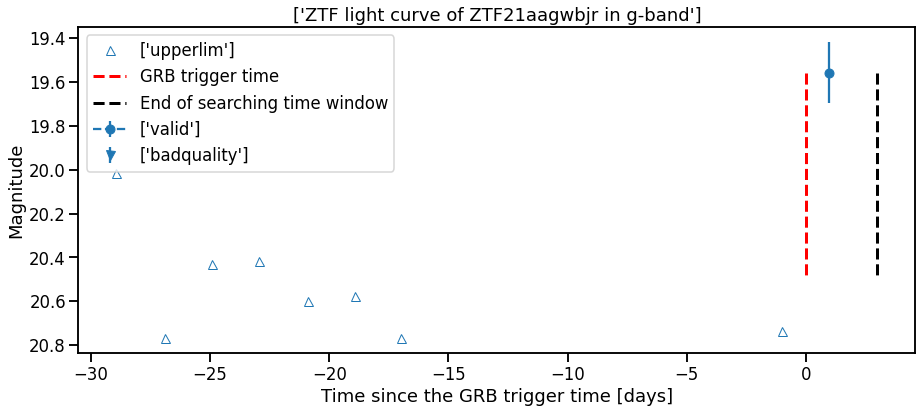

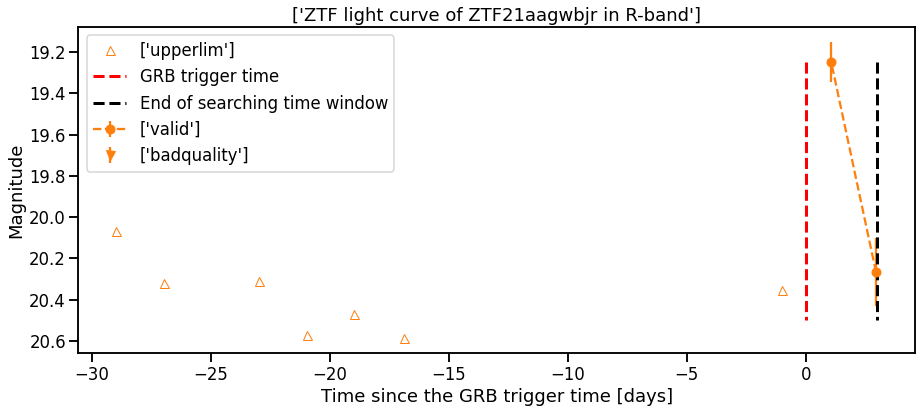

In [5]:
for pdf_object in list_pdf_ft_sub:
    plot_cand_lc(pdf_object, grb_date,size_time_window)
    